# Import

In [1]:
import pandas as pd
import numpy as np

import os, sys
# Adding parent directory to python path
sys.path.append(os.path.dirname(os.getcwd()))

import ml_workflow
from ml_workflow.rule import Rule

import sqlite3

# Pseudo covid 19

In [2]:
personnal_data_file = 'data/train.csv'
pcr_tests_db = 'data/pcr_tests.db'
consultation_db = 'data/consultations.db'


@ml_workflow.mlwf_data_source(name='Personnal data csv file')
def retrieve_personnal_data():
    return pd.read_csv(personnal_data_file)

@ml_workflow.mlwf_data_source(name='Retrieve pcr tests')
def retrieve_pcr_tests():
    conn = sqlite3.connect(pcr_tests_db)
    return pd.read_sql(
        'SELECT id, person_id, pcr_result, test_date FROM pcr_test ORDER BY id',
        conn
    )

@ml_workflow.mlwf_data_source(name='Retrieve data source')
def retrieve_visites():
    conn = sqlite3.connect(consultation_db)
    return pd.read_sql(
        'SELECT id, person_id, services, hospital, consultation_date FROM consultations ORDER BY id',
        conn
    )

def get_patients_status():
    personnal_df = retrieve_personnal_data()
    print(personnal_df.ml_workflow_current_node.origin)
    
    with Rule(name='select_with_age', highlight=2):
        personnal_df = personnal_df[np.logical_not(personnal_df['age'].isna())]
        
    return personnal_df

def get_patients_pcr_positives():
    patient_status = get_patients_status()
    
    tests_pcr = retrieve_pcr_tests()
    
    with Rule(name='pcr positif'):
        tests_pcr = tests_pcr[tests_pcr['pcr_result'] == 'positive']
    
    with Rule(name='pcr_positif_merge'):
        return patient_status.merge(tests_pcr, left_on='id', right_on='person_id')
    
def get_consultations():
    return retrieve_visites()


## Sqlite3 play-ground

## Pandas play-ground

# User code

Personnal data csv file


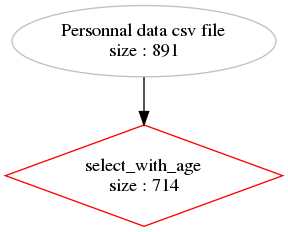

In [3]:
patient_status = get_patients_status()

patient_status.plot_model('graph.svg')
patient_status.plot_model('graph.png')

Personnal data csv file


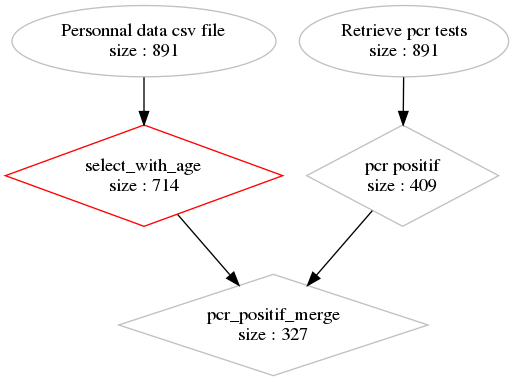

In [4]:
get_patients_pcr_positives().plot_model('graph.png')

Personnal data csv file


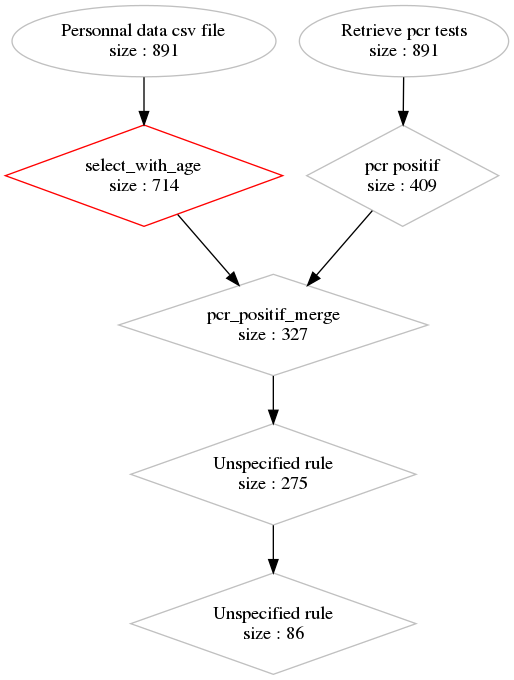

In [5]:
patients = get_patients_pcr_positives()

my_patient_status = patients[patients['age'] >= 18]
my_patient_status = my_patient_status[my_patient_status['sex'] == 'female']

my_patient_status.plot_model('graph.png')

In [6]:
from ml_workflow.session import Session   
    

with Session.record_data_source('temp/test_session_record'):
    patients = get_patients_pcr_positives()

print(f"Nb patients : {len(patients)}")

conn = sqlite3.connect(pcr_tests_db)
conn.execute("UPDATE pcr_test SET pcr_result = 'Positif' WHERE pcr_result = 'positive'")
conn.commit()

patients = get_patients_pcr_positives()
print(f"Nb patients : {len(patients)}")



Personnal data csv file
Nb patients : 327
Personnal data csv file
Nb patients : 0
